# DEKAE: Dynamic Edge-driven Topology for Episodic Few-Shot Learning
## Extension of FSAKE with Supervised Relational Recovery

**Paper identity**: *A topology-learning framework with explicit structural regularization and supervised relational recovery for episodic few-shot learning.*

| Section | Description |
|---------|-------------|
| 1 | Environment Setup & GPU Check |
| 2 | Data Pipeline (Local) |
| 3 | Dataset & Episodic Loader |
| 4 | Backbone (Conv4) |
| 5 | Static k-NN Graph Module (FSAKE Baseline) |
| 6 | Edge Incidence Matrix & Dynamic Edge Features |
| 7 | Adaptive Topology Reconstruction |
| 8 | Knowledge Filtering with Edge Awareness |
| 9 | Supervised Edge Loss (Support-Support Only) |
| 10 | Sparsity Regularization |
| 11 | Full Model Assembly (DEKAE) |
| 12 | Training Loop with Checkpointing |
| **12b** | **Execute Training ← RUN THIS to train on CIFAR-FS** |
| 13 | Evaluation & Statistical Testing (dummy sanity check) |
| **13b** | **Real Test-Set Evaluation ← RUN AFTER 12b** |
| 14 | Synthetic Graph Recovery Experiment |
| 15 | Ablation Study Runner |
| **15b** | **Execute Ablation Groups A + E ← RUN AFTER 12b** |
| 16 | Metrics Logging (W&B) |
| 17 | Visualization Suite |

---
**Execution order for a full run:**
1. Run cells 1–3 (setup, data, loaders)
2. Run cells 4–12 (architecture definitions)
3. ▶ **Run cell 12b** — starts real training (~60–90 min on T4)
4. ▶ **Run cell 13b** — evaluates on test set, prints accuracy table
5. ▶ **Run cell 14** — synthetic topology recovery (trained model)
6. ▶ **Run cell 15b** — ablation sweeps (Groups A & E)


## Section 2: Data Pipeline (Local)

In [1]:
# ── Section 1: Environment Setup & Dependencies ──────────────────────────────
# Run once per Colab session. Installs torch-geometric matching the Colab CUDA version.

import sys
import torch
import os

# 1. Downgrade setuptools to avoid build errors with older packages
!pip install -q "setuptools<70" wheel Cython

# 2. Install standard dependencies
!pip install -q torch-geometric wandb scipy scikit-learn matplotlib seaborn networkx tqdm Pillow

# 3. Install learn2learn from source in editable mode (bypasses wheel build failure)
if not os.path.exists("learn2learn"):
    !git clone https://github.com/learnables/learn2learn.git

# Install with -e (editable) to skip bdist_wheel
!cd learn2learn && pip install -e .

print("PyTorch version :", torch.__version__)
print("CUDA available  :", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU             :", torch.cuda.get_device_name(0))
    print("VRAM            :", round(torch.cuda.get_device_properties(0).total_memory / 1e9, 2), "GB")
else:
    print("⚠ No GPU detected — switch Runtime → Change runtime type → GPU")

# ── Reproducibility ───────────────────────────────────────────────────────────
import random, numpy as np

GLOBAL_SEED = 42

def set_seed(seed: int = GLOBAL_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 894.6/894.6 kB 20.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.0 MB/s eta 0:00:00
Cloning into 'learn2learn'...
remote: Enumerating objects: 4881, done.
remote: Counting objects: 100% (1221/1221), done.
remote: Compressing objects: 100% (307/307), done.
remote: Total 4881 (delta 1041), reused 914 (delta 914), pack-reused 3660 (from 1)
Receiving objects: 100% (4881/4881), 9.46 MiB | 17.18 MiB/s, done.
Resolving deltas: 100% (2834/2834), done.
Obtaining file:///content/learn2learn
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 47.2 MB/s eta 0:00:00
  Pre

## Section 2: Google Drive Mount & Data Pipeline

In [2]:
# ── Section 2: Data Download + Local Project Setup ───────────────────────────
# Strategy:
#   • Datasets are downloaded automatically via learn2learn (no manual work).
#   • Downloaded data lives on /content/data  (fast local SSD).
#   • Checkpoints & results are saved to /content/FSAKE_Project (local SSD).
#     They persist for the lifetime of the session. Download anything you want
#     to keep before the runtime resets (Files panel → right-click → Download).
#     No Google Drive required.
#
# Supported datasets (all download automatically on first run):
#   ACTIVE_DATASET = 'miniImageNet'   ← change to switch dataset
#   Other options : 'tieredImageNet' | 'cifarFS' | 'cub'

import shutil, pathlib, zipfile, sys, os

# ── Fix Import Shadowing ─────────────────────────────────────────────────────
# The repo is at /content/learn2learn. The package is /content/learn2learn/learn2learn.
# If CWD is /content, 'import learn2learn' finds the repo folder (namespace pkg) first.

# 1. Force reload if already loaded incorrectly
if "learn2learn" in sys.modules:
    import learn2learn
    # If it lacks __file__, it's likely the namespace package (broken)
    if not hasattr(learn2learn, "__file__") or learn2learn.__file__ is None:
        print("Creating fix: unloading broken learn2learn module...")
        del sys.modules["learn2learn"]

# 2. Prepend repo path to sys.path so the inner package is found first
if os.path.exists("/content/learn2learn"):
    if "/content/learn2learn" not in sys.path:
        sys.path.insert(0, "/content/learn2learn")

import learn2learn as l2l
print(f"learn2learn imported from: {getattr(l2l, '__file__', 'unknown')}")

# ─────────────────────────────────────────────────────────────────────────────

# SWITCHED TO cifarFS for reliability (miniImageNet download is often unstable)
ACTIVE_DATASET  = 'cifarFS'
LOCAL_DATA_ROOT = pathlib.Path("/content/data")
LOCAL_DATA_ROOT.mkdir(parents=True, exist_ok=True)

# ── Step 1: Download dataset via learn2learn ─────────────────────────────────
from learn2learn.vision.datasets import (
    MiniImagenet, TieredImagenet, CIFARFS, CUBirds200
)

from torchvision import transforms

MEAN = [0.4712, 0.4499, 0.4031]
STD  = [0.2726, 0.2634, 0.2794]

BASE_TRANSFORM = transforms.Compose([
    transforms.Resize(84),
    transforms.CenterCrop(84),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])
AUG_TRANSFORM = transforms.Compose([
    transforms.RandomResizedCrop(84),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

DATASET_CLS = {
    'miniImageNet' : MiniImagenet,
    'tieredImageNet': TieredImagenet,
    'cifarFS'      : CIFARFS,
    'cub'          : CUBirds200,
}

print(f"Downloading / loading {ACTIVE_DATASET} …")
cls = DATASET_CLS[ACTIVE_DATASET]

# download=True fetches the data automatically on first run.
# Subsequent runs reuse the cached copy in LOCAL_DATA_ROOT.
try:
    train_dataset = cls(root=str(LOCAL_DATA_ROOT), mode='train',
                        download=True, transform=BASE_TRANSFORM)
    val_dataset   = cls(root=str(LOCAL_DATA_ROOT), mode='validation',
                        download=True, transform=BASE_TRANSFORM)
    test_dataset  = cls(root=str(LOCAL_DATA_ROOT), mode='test',
                        download=True, transform=BASE_TRANSFORM)

    # Wrap in MetaDataset to ensure labels_to_indices exists (needed for EpisodicSampler)
    train_dataset = l2l.data.MetaDataset(train_dataset)
    val_dataset   = l2l.data.MetaDataset(val_dataset)
    test_dataset  = l2l.data.MetaDataset(test_dataset)

    print(f"{ACTIVE_DATASET} — "
          f"train: {len(train_dataset.labels_to_indices)} classes, "
          f"val: {len(val_dataset.labels_to_indices)} classes, "
          f"test: {len(test_dataset.labels_to_indices)} classes")
    print(f"Data stored at : {LOCAL_DATA_ROOT}")

except Exception as e:
    print(f"\n❌ Error downloading {ACTIVE_DATASET}: {e}")
    print("Tip: If miniImageNet fails, try switching ACTIVE_DATASET to 'cifarFS' or 'tieredImageNet'.")
    raise e

# ── Step 2: Local checkpoint / results directories ────────────────────────────
# Saves everything to the Colab instance SSD — no Google Drive needed.
# To keep results after the session ends, use the Files panel (left sidebar)
# to download checkpoints/results before the runtime resets.
LOCAL_PROJECT_ROOT = pathlib.Path("/content/FSAKE_Project")

CKPT_DIR    = LOCAL_PROJECT_ROOT / "checkpoints"
RESULTS_DIR = LOCAL_PROJECT_ROOT / "results"
CKPT_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("CKPT dir    :", CKPT_DIR)
print("Results dir :", RESULTS_DIR)


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


learn2learn imported from: /content/learn2learn/learn2learn/__init__.py


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Creating CIFARFS splits
cifarFS — train: 64 classes, val: 16 classes, test: 20 classes
Data stored at : /content/data
CKPT dir    : /content/FSAKE_Project/checkpoints
Results dir : /content/FSAKE_Project/results


## Section 3: Dataset & Episodic Loader

In [3]:
# ── Section 3: Dataset & Episodic Loader ─────────────────────────────────────
# Wraps the learn2learn datasets (loaded in Section 2) into a simple episodic
# sampler. Works with miniImageNet, tieredImageNet, CIFAR-FS, and CUB.
#
# Episodic protocol:
#   S = N_way × K_shot  support samples  (labeled)
#   Q = N_way × N_query query  samples  (unlabeled at inference)

import torch
import torch.nn.functional as F

# ── Generic episodic sampler wrapping any learn2learn dataset ─────────────────

class EpisodicSampler:
    """
    Wraps a learn2learn dataset (which exposes `labels_to_indices` dict)
    and samples N-way K-shot episodes on demand.

    Usage:
        sampler = EpisodicSampler(train_dataset, n_way=5, k_shot=1, n_query=15)
        s_imgs, s_lbl, q_imgs, q_lbl = sampler.sample()   # one episode

    Can also be called as a function (for compatibility with train/eval loops):
        s_imgs, s_lbl, q_imgs, q_lbl = sampler(n_way=5, k_shot=1, n_query=15)
    """

    def __init__(self, dataset, n_way: int = 5, k_shot: int = 1,
                 n_query: int = 15):
        self.dataset  = dataset
        self.n_way    = n_way
        self.k_shot   = k_shot
        self.n_query  = n_query

        # Build class → list[global_index] map
        if hasattr(dataset, 'labels_to_indices'):
            self.class_to_indices = {
                c: list(idxs)
                for c, idxs in dataset.labels_to_indices.items()
                if len(idxs) >= k_shot + n_query
            }
        elif hasattr(dataset, 'y'):
            import numpy as _np
            _labels = _np.array(dataset.y)
            self.class_to_indices = {
                int(c): list(_np.where(_labels == c)[0])
                for c in _np.unique(_labels)
                if len(_np.where(_labels == c)[0]) >= k_shot + n_query
            }
        else:
            raise ValueError("Dataset must expose .labels_to_indices or .y")

        self.classes = sorted(self.class_to_indices.keys())
        assert len(self.classes) >= n_way, (
            f"Only {len(self.classes)} classes available, N-way={n_way}")
        print(f"EpisodicSampler ready: {len(self.classes)} classes, "
              f"{n_way}-way {k_shot}-shot {n_query}-query")

    def sample(self):
        """Returns (support_imgs, support_labels, query_imgs, query_labels)."""
        episode_classes = random.sample(self.classes, self.n_way)
        s_imgs, s_labels, q_imgs, q_labels = [], [], [], []
        for local_lbl, cls in enumerate(episode_classes):
            pool = random.sample(self.class_to_indices[cls],
                                 self.k_shot + self.n_query)
            for i, idx in enumerate(pool):
                img, _ = self.dataset[idx]       # transform applied by dataset
                if not isinstance(img, torch.Tensor):
                    from torchvision.transforms.functional import to_tensor
                    img = to_tensor(img)
                if i < self.k_shot:
                    s_imgs.append(img);   s_labels.append(local_lbl)
                else:
                    q_imgs.append(img);   q_labels.append(local_lbl)
        return (torch.stack(s_imgs),  torch.tensor(s_labels, dtype=torch.long),
                torch.stack(q_imgs),  torch.tensor(q_labels, dtype=torch.long))

    def __call__(self, n_way=None, k_shot=None, n_query=None):
        """Allow calling as episode_fn(n_way, k_shot, n_query) for loop compat."""
        if n_way   is not None: self.n_way   = n_way
        if k_shot  is not None: self.k_shot  = k_shot
        if n_query is not None: self.n_query = n_query
        return self.sample()


# ── Instantiate samplers for all three splits ─────────────────────────────────
train_sampler = EpisodicSampler(train_dataset, n_way=5, k_shot=1, n_query=15)
val_sampler   = EpisodicSampler(val_dataset,   n_way=5, k_shot=1, n_query=15)
test_sampler  = EpisodicSampler(test_dataset,  n_way=5, k_shot=1, n_query=15)

# Augmented training sampler (same data, richer color/crop augmentation)
train_dataset_aug = DATASET_CLS[ACTIVE_DATASET](
    root=str(LOCAL_DATA_ROOT), mode='train',
    download=False, transform=AUG_TRANSFORM)
# FIX: Wrap train_dataset_aug with l2l.data.MetaDataset
train_dataset_aug = l2l.data.MetaDataset(train_dataset_aug)
train_sampler_aug = EpisodicSampler(train_dataset_aug, n_way=5, k_shot=1, n_query=15)

# ── Quick episode sanity check ────────────────────────────────────────────────
_s_imgs, _s_lbl, _q_imgs, _q_lbl = train_sampler.sample()
print(f"Support : {_s_imgs.shape}  labels={_s_lbl.tolist()}")
print(f"Query   : {_q_imgs.shape}  labels={_q_lbl[:5].tolist()}…")

# ── Synthetic planted-partition episode generator (Section 2.3) ───────────────

def synthetic_episode(n_way=5, n_nodes_per_class=5, feat_dim=64,
                      sigma=0.8, device=DEVICE):
    """
    Generate a planted-partition episode for topology-recovery experiments.
    Returns node features X, labels y, and ground-truth adjacency A_star.
    sigma controls noise: larger sigma → harder topology recovery.
    """
    centers = torch.randn(n_way, feat_dim)
    center_dists = [
        (centers[i] - centers[j]).norm().item()
        for i in range(n_way)
        for j in range(i + 1, n_way)
    ]
    avg_sep = sum(center_dists) / len(center_dists)

    N = n_way * n_nodes_per_class
    X = torch.zeros(N, feat_dim)
    y = torch.zeros(N, dtype=torch.long)
    for c in range(n_way):
        sl = slice(c * n_nodes_per_class, (c + 1) * n_nodes_per_class)
        X[sl] = centers[c] + sigma * avg_sep * torch.randn(n_nodes_per_class, feat_dim)
        y[sl] = c

    # Ground-truth: intra-class = 1, inter-class = 0, no self-loops
    A_star = (y.unsqueeze(0) == y.unsqueeze(1)).float()
    A_star.fill_diagonal_(0)
    return X.to(device), y.to(device), A_star.to(device)


# ── Quick sanity check ────────────────────────────────────────────────────────
X_syn, y_syn, A_syn = synthetic_episode(n_way=5, n_nodes_per_class=4, feat_dim=64, sigma=0.6)
print(f"Synthetic X:{X_syn.shape}  y:{y_syn.shape}  A*:{A_syn.shape}")
print(f"Intra-class edges: {int(A_syn.sum().item())} "
      f"(expected {5 * 4 * 3} for 5 classes, 4 nodes each)")

EpisodicSampler ready: 64 classes, 5-way 1-shot 15-query
EpisodicSampler ready: 16 classes, 5-way 1-shot 15-query
EpisodicSampler ready: 20 classes, 5-way 1-shot 15-query
EpisodicSampler ready: 64 classes, 5-way 1-shot 15-query
Support : torch.Size([5, 3, 84, 84])  labels=[0, 1, 2, 3, 4]
Query   : torch.Size([75, 3, 84, 84])  labels=[0, 0, 0, 0, 0]…
Synthetic X:torch.Size([20, 64])  y:torch.Size([20])  A*:torch.Size([20, 20])
Intra-class edges: 60 (expected 60 for 5 classes, 4 nodes each)


## Section 4: Backbone Network (Conv4)
Bit-for-bit identical to the FSAKE backbone. 128-dim output embedding.

In [4]:
# ── Section 4: Backbone Network (Conv4) ──────────────────────────────────────
import torch.nn as nn

def conv_block(in_ch: int, out_ch: int) -> nn.Sequential:
    """Standard FSAKE conv block: Conv → BN → ReLU → MaxPool."""
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),
    )


class Conv4(nn.Module):
    """
    4-layer convolutional backbone identical to FSAKE.
    Input : (B, 3, 84, 84)
    Output: (B, embed_dim) — default 128 to match FSAKE paper.
    """

    def __init__(self, in_channels: int = 3, embed_dim: int = 128):
        super().__init__()
        self.encoder = nn.Sequential(
            conv_block(in_channels, 64),   # → 42×42
            conv_block(64, 64),            # → 21×21
            conv_block(64, 64),            # → 10×10
            conv_block(64, 64),            # →  5× 5
        )
        self.proj = nn.Linear(64 * 5 * 5, embed_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.encoder(x)                          # (B, 64, 5, 5)
        h = h.view(h.size(0), -1)                    # (B, 1600)
        return self.proj(h)                          # (B, embed_dim)


# ── Sanity check ─────────────────────────────────────────────────────────────
_backbone = Conv4(embed_dim=128).to(DEVICE)
_dummy    = torch.randn(10, 3, 84, 84).to(DEVICE)
_out      = _backbone(_dummy)
print("Conv4 output shape:", _out.shape)   # expect (10, 128)
assert _out.shape == (10, 128), "Backbone shape mismatch!"
total_params = sum(p.numel() for p in _backbone.parameters() if p.requires_grad)
print(f"Conv4 trainable parameters: {total_params:,}")

Conv4 output shape: torch.Size([10, 128])
Conv4 trainable parameters: 317,760


## Section 5: Static k-NN Graph Module (FSAKE Baseline)

In [5]:
# ── Section 5: Static k-NN Graph Module (FSAKE Baseline) ─────────────────────
# Builds A ∈ R^{N×N} from pairwise Euclidean distances; retains top-k per node.
# This is the graph construction used by FSAKE — plug-in swappable.

def build_knn_adjacency(node_feats: torch.Tensor, k: int,
                        symmetric: bool = True) -> torch.Tensor:
    """
    Args
    ----
    node_feats : (N, d) node embeddings
    k          : number of nearest neighbours per node
    symmetric  : if True, A = max(A, A^T) (undirected graph)

    Returns
    -------
    A : (N, N) float adjacency (0/1 values, no self-loops, row-normalised)
    """
    N = node_feats.size(0)
    # Pairwise squared Euclidean distance
    diff = node_feats.unsqueeze(0) - node_feats.unsqueeze(1)   # (N,N,d)
    dist = (diff ** 2).sum(-1)                                  # (N,N)

    # Mask self (set diagonal to large value so it is not selected in top-k)
    dist_masked = dist.clone()
    dist_masked.fill_diagonal_(float("inf"))

    # Keep k SMALLEST distances (nearest neighbours) → set all others to 0
    _, topk_idx = dist_masked.topk(k, dim=1, largest=False)
    A = torch.zeros(N, N, dtype=torch.float32, device=node_feats.device)
    A.scatter_(1, topk_idx, 1.0)

    if symmetric:
        A = torch.max(A, A.t())

    # Row-normalise (D^{-1} A)
    deg = A.sum(dim=1, keepdim=True).clamp(min=1e-6)
    A_norm = A / deg
    return A_norm


# ── Graph utility: density ────────────────────────────────────────────────────

def graph_density(A: torch.Tensor) -> float:
    """Fraction of possible directed edges that are non-zero (excl. diagonal)."""
    N = A.size(0)
    possible = N * (N - 1)
    actual   = (A > 0).float().sum().item() - (A.diagonal() > 0).float().sum().item()
    density  = actual / possible if possible > 0 else 0.0
    if density > 0.5:
        print(f"⚠  Graph density = {density:.3f} > 0.5 — risk of topology collapse!")
    return density


# ── Sanity check ─────────────────────────────────────────────────────────────
_feats = torch.randn(20, 128).to(DEVICE)
_A_knn = build_knn_adjacency(_feats, k=5)
d = graph_density(_A_knn)
print(f"k-NN adjacency shape: {_A_knn.shape}  density: {d:.3f}")

k-NN adjacency shape: torch.Size([20, 20])  density: 0.405


## Section 6: Edge Incidence Matrix & Dynamic Edge Features

**Key distinction from attention**: Attention produces a *scalar* weight per edge. Computing $E = BXW$ via the incidence matrix $B \in \{0,1\}^{N \times |E|}$ produces a *vector* $e_{ij} \in \mathbb{R}^d$ per edge — a $d$-dimensional signal retaining directional and heterogeneous relational information. This is equivalent to one step of line-graph convolution, where edges are first-class computational objects.

In [6]:
# ── Section 6: Edge Incidence Matrix & Dynamic Edge Features ─────────────────
# B ∈ {0,1}^{N × |E|}  maps each edge to its two incident nodes.
# E = B^T X W  →  each edge gets a vector representation in R^d.

class EdgeIncidenceModule(nn.Module):
    """
    Builds the edge incidence matrix B from a given adjacency A,
    then computes edge features E = B^T X W using a shallow MLP.

    Parameters
    ----------
    in_dim  : node feature dimension d
    edge_dim: output edge feature dimension (default = in_dim for skip-compat.)
    hidden  : hidden dim of the 2-layer edge MLP (≤ 64 to avoid overfit)
    """

    def __init__(self, in_dim: int, edge_dim: int = None, hidden: int = 64):
        super().__init__()
        edge_dim = edge_dim or in_dim
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * in_dim, hidden, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, edge_dim, bias=True),
        )

    @staticmethod
    def adjacency_to_edge_index(A: torch.Tensor):
        """Return (src, dst) index arrays for all non-zero entries of A."""
        nz = A.nonzero(as_tuple=True)
        return nz[0], nz[1]         # src, dst

    def forward(self, X: torch.Tensor, A: torch.Tensor):
        """
        X : (N, d)  node features
        A : (N, N)  adjacency (may be weighted)

        Returns
        -------
        E         : (|E|, edge_dim)  vector edge features
        src, dst  : edge index tensors
        """
        src, dst = self.adjacency_to_edge_index(A)
        # Concatenate incident node features for each edge
        edge_input = torch.cat([X[src], X[dst]], dim=-1)    # (|E|, 2d)
        E = self.edge_mlp(edge_input)                        # (|E|, edge_dim)
        return E, src, dst


# ── Sanity check ─────────────────────────────────────────────────────────────
_eim   = EdgeIncidenceModule(in_dim=128, edge_dim=128, hidden=64).to(DEVICE)
_feats = torch.randn(20, 128).to(DEVICE)
_A     = build_knn_adjacency(_feats, k=5)
_E, _src, _dst = _eim(_feats, _A)
print(f"Edge features shape : {_E.shape}   (|E|={len(_src)}, edge_dim=128)")
print(f"src index range     : {_src.min().item()} – {_src.max().item()}")

Edge features shape : torch.Size([136, 128])   (|E|=136, edge_dim=128)
src index range     : 0 – 19


## Section 7: Adaptive Topology Reconstruction

Low-rank bilinear scoring: $s_{ij} = (W_1 h_i)^\top (W_2 h_j)$ with rank $r \ll d$ bounds overfitting. Spectral normalization bounds $L_f$ (Lipschitz). Row-normalisation of $A'$ bounds $L_{MP}$. Together they ensure contraction (Proposition 3).

In [7]:
# ── Section 7: Adaptive Topology Reconstruction ───────────────────────────────
from torch.nn.utils.parametrizations import spectral_norm as spectral_norm_wrap

class DynamicTopologyModule(nn.Module):
    """
    Learns A'(l) = f(H(l)) using low-rank bilinear scoring.

    s_ij = (W1 h_i)^T (W2 h_j) / sqrt(r)     [low-rank, rank r << d]

    Spectral normalization on W1,W2 → Lipschitz bound on f.
    Row-normalization of A'          → Lipschitz bound on MP.

    sparsity_mode ∈ {'none', 'l1', 'topk', 'laplacian'}
    """

    def __init__(self, feat_dim: int, rank: int = 16, edge_dim: int = 128,
                 sparsity_mode: str = "l1", topk: int = 5,
                 lambda_sparse: float = 0.01, edge_dropout: float = 0.1):
        super().__init__()
        self.rank          = rank
        self.sparsity_mode = sparsity_mode
        self.topk          = topk
        self.lambda_sparse = lambda_sparse
        self.edge_dropout  = edge_dropout

        # Low-rank projection (spectral-normalised)
        self.W1 = spectral_norm_wrap(nn.Linear(feat_dim, rank, bias=False))
        self.W2 = spectral_norm_wrap(nn.Linear(feat_dim, rank, bias=False))

        # Edge → A' scoring via edge feature dot-product
        self.edge_scorer = spectral_norm_wrap(
            nn.Linear(edge_dim, 1, bias=False))

    def forward(self, H: torch.Tensor, E: torch.Tensor,
                src: torch.Tensor, dst: torch.Tensor,
                sparsity_reg: bool = True):
        """
        H   : (N, d)      node features
        E   : (|E|, d_e)  edge features from EdgeIncidenceModule
        src,dst : edge indices

        Returns
        -------
        A_prime       : (N, N)  new normalised adjacency
        sparsity_loss : scalar  (0 if sparsity_reg=False)
        """
        N = H.size(0)

        # ── Low-rank bilinear scores ─────────────────────────────────────────
        scores_bilinear = (self.W1(H[src]) * self.W2(H[dst])).sum(-1) / (self.rank ** 0.5)

        # ── Edge-feature scores ──────────────────────────────────────────────
        scores_edge     = self.edge_scorer(E).squeeze(-1)

        edge_scores = scores_bilinear + scores_edge

        # ── Dropout on edge weights during training ──────────────────────────
        if self.training and self.edge_dropout > 0:
            mask = torch.bernoulli(
                torch.full_like(edge_scores, 1 - self.edge_dropout))
            edge_scores = edge_scores * mask

        # ── Soft adjacency via sigmoid ────────────────────────────────────────
        edge_weights = torch.sigmoid(edge_scores)

        # ── Build dense A' ────────────────────────────────────────────────────
        A_prime = torch.zeros(N, N, device=H.device, dtype=H.dtype)
        A_prime[src, dst] = edge_weights

        # ── Sparsity regularisation ───────────────────────────────────────────
        sparsity_loss = torch.tensor(0.0, device=H.device)
        if sparsity_reg:
            if self.sparsity_mode == "l1":
                sparsity_loss = self.lambda_sparse * A_prime.abs().mean()
            elif self.sparsity_mode == "topk":
                # Hard top-k mask (gradient stops here — ablation only)
                vals, idx = A_prime.topk(self.topk, dim=1)
                mask = torch.zeros_like(A_prime)
                mask.scatter_(1, idx, 1.0)
                A_prime = A_prime * mask.detach()
            elif self.sparsity_mode == "laplacian":
                # tr(H^T L H) where L = D - A'
                D = A_prime.sum(dim=1).diag()
                L = D - A_prime
                sparsity_loss = self.lambda_sparse * torch.trace(H.t() @ L @ H)

        # ── Row-normalise (Proposition 3 Lipschitz control) ──────────────────
        deg = A_prime.sum(dim=1, keepdim=True).clamp(min=1e-6)
        A_prime = A_prime / deg

        return A_prime, sparsity_loss


# ── Sanity check ─────────────────────────────────────────────────────────────
_dtm   = DynamicTopologyModule(feat_dim=128, rank=16, edge_dim=128).to(DEVICE)
_A_dyn, _sl = _dtm(_feats, _E, _src, _dst)
print(f"Dynamic A' shape: {_A_dyn.shape}  sparsity_loss={_sl.item():.4f}")
print(f"Graph density   : {graph_density(_A_dyn):.3f}")

Dynamic A' shape: torch.Size([20, 20])  sparsity_loss=0.0019
Graph density   : 0.358


## Section 8: Knowledge Filtering with Edge Awareness

In [8]:
# ── Section 8: Knowledge Filtering with Edge Awareness ───────────────────────
# Node importance is now computed from aggregated *edge* representations
# rather than raw 1-hop degree counts (as in vanilla FSAKE).
# High-importance nodes gate the pooling step in the Graph U-Net path.

class EdgeAwareKnowledgeFilter(nn.Module):
    """
    Scores each node by aggregating its incident edge features, then
    applies a learnable gating MLP to produce a scalar importance score.

    importance_i = sigmoid( g( mean_{j: (i,j)∈E} e_{ij} ) )

    The scores are used for top-p node selection (Graph U-Net pooling analog).
    """

    def __init__(self, edge_dim: int, node_dim: int, hidden: int = 64):
        super().__init__()
        self.gate = nn.Sequential(
            nn.Linear(edge_dim + node_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, 1),
        )

    def forward(self, H: torch.Tensor, E: torch.Tensor,
                src: torch.Tensor, A_prime: torch.Tensor) -> torch.Tensor:
        """
        H       : (N, d)
        E       : (|E|, edge_dim)
        src     : edge src indices
        A_prime : (N, N) row-normalised dynamic adjacency

        Returns
        -------
        scores  : (N,) importance scores in [0,1]
        H_pooled: (N, d) weighted node update  X' = A' E W'  via scatter
        """
        N = H.size(0)
        edge_dim = E.size(1)

        # Aggregate edge features per source node: mean of incident edges
        agg = torch.zeros(N, edge_dim, device=H.device)
        agg.scatter_add_(0, src.unsqueeze(-1).expand_as(E), E)
        counts = torch.zeros(N, device=H.device).scatter_add_(
            0, src, torch.ones(len(src), device=H.device))
        agg = agg / counts.unsqueeze(-1).clamp(min=1)

        # Gate: importance score from (aggregated edge features ∥ node feat)
        gate_input = torch.cat([agg, H], dim=-1)
        scores     = torch.sigmoid(self.gate(gate_input)).squeeze(-1)   # (N,)

        # Edge-to-node update: X' = A' · scatter(E) → message passing
        H_pooled = A_prime @ H                              # (N, d) simple MP
        H_pooled = H_pooled * scores.unsqueeze(-1)          # gate by importance

        return scores, H_pooled


# ── Sanity check ─────────────────────────────────────────────────────────────
_kf = EdgeAwareKnowledgeFilter(edge_dim=128, node_dim=128).to(DEVICE)
_scores, _H_pool = _kf(_feats, _E, _src, _A_dyn)
print(f"Node scores shape : {_scores.shape}")
print(f"H_pooled shape    : {_H_pool.shape}")
print(f"Score range       : [{_scores.min():.3f}, {_scores.max():.3f}]")

Node scores shape : torch.Size([20])
H_pooled shape    : torch.Size([20, 128])
Score range       : [0.442, 0.549]


## Section 9: Supervised Edge Loss (Support-Support Only)

**Label-leakage prevention (Risk 5)**: The correction loss is computed **only on support-support pairs**. Query nodes never appear as supervision targets — they receive topology updates passively via message passing from the learned support graph.

$$\mathcal{L}_{edge} = \sum_{i,j \in \mathcal{S}} \mathbb{1}[y_i = y_j](1 - \cos(e_{ij})) + \mathbb{1}[y_i \neq y_j]\max(0, \cos(e_{ij}) - m)$$

In [9]:
# ── Section 9: Supervised Edge Loss (Support-Support Only) ───────────────────

def edge_correction_loss(E: torch.Tensor,
                         src: torch.Tensor,
                         dst: torch.Tensor,
                         labels: torch.Tensor,
                         support_mask: torch.Tensor,
                         margin: float = 0.5) -> torch.Tensor:
    """
    Computes the edge-level contrastive correction loss.

    IMPORTANT: only support→support edges are used.
    An assertion guarantees no query indices leak into this computation.

    Parameters
    ----------
    E            : (|E|, d)  edge features from EdgeIncidenceModule
    src, dst     : edge endpoint indices (for ALL edges in the graph)
    labels       : (N,) — labels for support nodes; query labels NOT used
    support_mask : (N,) bool — True if node i is in the support set
    margin       : contrastive margin m

    Returns
    -------
    loss : scalar
    """
    # ── Strict label-leakage guard ────────────────────────────────────────────
    support_indices = support_mask.nonzero(as_tuple=True)[0]
    support_set     = set(support_indices.cpu().tolist())

    # Keep only support-support edges
    ss_mask = support_mask[src] & support_mask[dst]

    # ASSERT: no query node sneaks into the loss
    assert ss_mask.sum().item() <= (support_mask.sum() ** 2).item(), \
        "Edge loss applied to non-support edges — label leakage!"

    if ss_mask.sum().item() == 0:
        return torch.tensor(0.0, device=E.device, requires_grad=True)

    E_ss   = E[ss_mask]
    src_ss = src[ss_mask]
    dst_ss = dst[ss_mask]

    # Cosine similarity between edge endpoint features (proxy: edge features)
    cos_sim = F.cosine_similarity(E_ss[:, :E_ss.size(1)//2],
                                  E_ss[:, E_ss.size(1)//2:], dim=-1)
    # For the actual implementation use the edge vectors directly:
    # cos_sim = F.cosine_similarity(E_ss, ...) — simplified here

    same_class = (labels[src_ss] == labels[dst_ss]).float()

    pull_loss = same_class       * (1 - cos_sim)
    push_loss = (1 - same_class) * torch.clamp(cos_sim - margin, min=0)

    return (pull_loss + push_loss).mean()


# ── Sanity check ─────────────────────────────────────────────────────────────
# Simulate 5-way 1-shot (5 support) + 15 query nodes
_N_total   = 20
_n_support = 5
_labels_s  = torch.arange(_n_support).to(DEVICE)              # support labels
_labels    = torch.cat([_labels_s,
                        torch.zeros(_N_total - _n_support, dtype=torch.long).to(DEVICE)])
_sup_mask  = torch.zeros(_N_total, dtype=torch.bool).to(DEVICE)
_sup_mask[:_n_support] = True

_loss_edge = edge_correction_loss(_E, _src, _dst, _labels, _sup_mask)
print(f"Edge correction loss (support-only): {_loss_edge.item():.4f}")

Edge correction loss (support-only): 0.0000


## Section 10: Sparsity Regularization

Three togglable options — L1 (default, preserves variable degree), Laplacian smoothness, and top-k hard mask (ablation only). `graph_density()` raises a warning above 0.5 to detect collapse.

In [10]:
# ── Section 10: Sparsity Regularization ──────────────────────────────────────
# Standalone helpers (also used inside DynamicTopologyModule).

def l1_sparsity_loss(A: torch.Tensor, lambda_: float = 0.01) -> torch.Tensor:
    """L1 regularisation on adjacency. Promotes sparse connectivity."""
    return lambda_ * A.abs().mean()


def laplacian_smoothness_loss(A: torch.Tensor, H: torch.Tensor,
                               lambda_: float = 0.01) -> torch.Tensor:
    """Laplacian smoothness: tr(H^T L H). Encourages connected nodes to agree."""
    D = A.sum(dim=1).diag()
    L = D - A
    return lambda_ * torch.trace(H.t() @ L @ H)


def topk_mask(A: torch.Tensor, k: int) -> torch.Tensor:
    """Hard top-k per row (ablation variant E3 ONLY — enforces fixed degree)."""
    # NOTE: gradient does not flow through this mask.
    _, idx = A.topk(k, dim=1)
    mask = torch.zeros_like(A)
    mask.scatter_(1, idx, 1.0)
    return A * mask.detach()


def graph_metrics(A: torch.Tensor) -> dict:
    """
    Returns a metrics dict for a single graph:
      graph_density, avg_degree, degree_std, edge_entropy.
    Raises a warning if density > 0.5.
    """
    N   = A.size(0)
    # Remove diagonal for degree counting
    A_no_diag = A.clone()
    A_no_diag.fill_diagonal_(0)

    degree    = (A_no_diag > 0).float().sum(dim=1)      # (N,)
    n_edges   = (A_no_diag > 0).float().sum().item()
    density   = n_edges / max(N * (N - 1), 1)

    # Edge entropy: treat each edge weight as a probability
    weights   = A_no_diag[A_no_diag > 0]
    p         = weights / weights.sum().clamp(min=1e-9)
    edge_ent  = -(p * (p + 1e-9).log()).sum().item()

    if density > 0.5:
        print(f"⚠  graph_density={density:.3f} > 0.5 — potential collapse")

    return {
        "graph_density": density,
        "avg_degree"   : degree.mean().item(),
        "degree_std"   : degree.std().item(),
        "edge_entropy" : edge_ent,
    }


# ── Demo ──────────────────────────────────────────────────────────────────────
_metrics = graph_metrics(_A_dyn)
print("Graph metrics:", {k: round(v, 4) for k, v in _metrics.items()})
print("L1 loss      :", l1_sparsity_loss(_A_dyn).item())

Graph metrics: {'graph_density': 0.3579, 'avg_degree': 6.8, 'degree_std': 2.858, 'edge_entropy': 4.8252}
L1 loss      : 0.0004999999655410647


## Section 11: Full Model Assembly (DEKAE)

Forward pass: `node features + B → edge features E → dynamic A' → node update X' → knowledge filtering → skip connections`.

Warm-up schedule: static k-NN topology for first `T_warm` epochs. Curriculum `λ_edge`: linearly ramps from 0 to `lambda_edge` over first 20 % of training.

In [11]:
# ── Section 11: Full Model Assembly (DEKAE) ───────────────────────────────────

class DEKAEModel(nn.Module):
    """
    Dynamic Edge-driven topology for Episodic few-shot learning (DEKAE).

    Architecture per GNN layer
    --------------------------
    1. EdgeIncidenceModule   : X, A(l) → E(l), src, dst
    2. DynamicTopologyModule : H(l), E(l) → A'(l), sparsity_loss
    3. EdgeAwareKnowledgeFilter : H(l), E(l), A'(l) → scores, H(l+1)
    4. Skip connection       : H(l+1) ← H(l+1) + H(0)

    Parameters
    ----------
    embed_dim     : backbone output dimension
    n_gnn_layers  : number of dynamic GNN layers (default 3)
    rank          : rank for low-rank bilinear scorer
    sparsity_mode : 'l1' | 'topk' | 'laplacian' | 'none'
    use_dynamic   : if False, fall back to static k-NN (FSAKE mode)
    knn_k         : k for static k-NN fallback
    """

    def __init__(self, embed_dim: int = 128, n_gnn_layers: int = 3,
                 rank: int = 16, sparsity_mode: str = "l1",
                 lambda_sparse: float = 0.01, lambda_edge: float = 0.5,
                 topk_k: int = 5, n_way: int = 5, use_dynamic: bool = True,
                 edge_dropout: float = 0.1):
        super().__init__()
        self.embed_dim     = embed_dim
        self.n_gnn_layers  = n_gnn_layers
        self.n_way         = n_way
        self.use_dynamic   = use_dynamic
        self.knn_k         = topk_k
        self.lambda_edge   = lambda_edge

        self.backbone = Conv4(embed_dim=embed_dim)

        self.edge_modules   = nn.ModuleList([
            EdgeIncidenceModule(embed_dim, embed_dim, hidden=64)
            for _ in range(n_gnn_layers)
        ])
        self.dynamic_modules = nn.ModuleList([
            DynamicTopologyModule(embed_dim, rank, embed_dim,
                                  sparsity_mode, topk_k, lambda_sparse,
                                  edge_dropout)
            for _ in range(n_gnn_layers)
        ])
        self.kf_modules = nn.ModuleList([
            EdgeAwareKnowledgeFilter(embed_dim, embed_dim)
            for _ in range(n_gnn_layers)
        ])

        self.classifier = nn.Linear(embed_dim, n_way)

    # ── Warm-up helpers ───────────────────────────────────────────────────────
    def set_use_dynamic(self, flag: bool):
        self.use_dynamic = flag

    # ── Forward ───────────────────────────────────────────────────────────────
    def forward(self, imgs_support: torch.Tensor, labels_support: torch.Tensor,
                imgs_query: torch.Tensor, lambda_edge_scale: float = 1.0):
        """
        imgs_support : (N_s, 3, 84, 84)
        labels_support : (N_s,)
        imgs_query   : (N_q, 3, 84, 84)
        lambda_edge_scale : curriculum multiplier [0,1] for edge loss

        Returns
        -------
        logits   : (N_q, n_way)
        aux_loss : edge correction loss + sparsity losses
        metrics  : dict with graph quality statistics
        """
        N_s = imgs_support.size(0)
        N_q = imgs_query.size(0)

        # ── 1. Encode all nodes ───────────────────────────────────────────────
        all_imgs  = torch.cat([imgs_support, imgs_query], dim=0)   # (N_s+N_q, ...)
        H0        = self.backbone(all_imgs)                         # (N, d)

        # Support mask (for edge loss — query nodes excluded)
        support_mask = torch.zeros(N_s + N_q, dtype=torch.bool,
                                   device=H0.device)
        support_mask[:N_s] = True

        H = H0
        total_sparsity_loss = torch.tensor(0.0, device=H0.device)
        total_edge_loss     = torch.tensor(0.0, device=H0.device)
        layer_stability     = []           # ||H(l+1) - H(l)||_F for Prop. 3

        for l in range(self.n_gnn_layers):
            # ── 2. Build initial adjacency (warm-up: static; else: expand) ───
            A_init = build_knn_adjacency(H, k=self.knn_k)

            # ── 3. Edge features ──────────────────────────────────────────────
            E, src, dst = self.edge_modules[l](H, A_init)

            if self.use_dynamic:
                # ── 4. Dynamic topology ───────────────────────────────────────
                A_prime, sp_loss = self.dynamic_modules[l](H, E, src, dst)
                total_sparsity_loss = total_sparsity_loss + sp_loss

                # ── 5. Edge correction loss (support-support only) ─────────────
                labels_full = torch.full((N_s + N_q,), -1, dtype=torch.long,
                                         device=H.device)
                labels_full[:N_s] = labels_support
                e_loss_l = edge_correction_loss(E, src, dst, labels_full,
                                                support_mask)
                total_edge_loss = total_edge_loss + e_loss_l * lambda_edge_scale
            else:
                A_prime = A_init         # static fallback (warm-up / FSAKE mode)

            # ── 6. Knowledge filtering & node update ──────────────────────────
            _, H_new = self.kf_modules[l](H, E, src, A_prime)
            H_new    = H_new + H0                                # skip connection

            # Layer representation stability diagnostic (Proposition 3)
            with torch.no_grad():
                stability = (H_new - H).norm().item()
            layer_stability.append(stability)

            H = H_new

        # ── 7. Classify query nodes via prototype cosine similarity ───────────
        H_support = H[:N_s]                                   # (N_s, d)
        H_query   = H[N_s:]                                   # (N_q, d)

        # Compute class prototypes
        prototypes = torch.zeros(self.n_way, self.embed_dim, device=H.device)
        for c in range(self.n_way):
            mask_c      = labels_support == c
            prototypes[c] = H_support[mask_c].mean(0)

        # Cosine similarity logits
        H_q_norm   = F.normalize(H_query, dim=-1)
        proto_norm = F.normalize(prototypes, dim=-1)
        logits     = H_q_norm @ proto_norm.t()                 # (N_q, n_way)

        aux_loss = (total_edge_loss * self.lambda_edge
                    + total_sparsity_loss)

        metrics = graph_metrics(A_prime)
        metrics["layer_stability"] = layer_stability

        return logits, aux_loss, metrics


# ── Sanity check ─────────────────────────────────────────────────────────────
_model = DEKAEModel(n_way=5, embed_dim=128).to(DEVICE)
_s_imgs = torch.randn(5, 3, 84, 84).to(DEVICE)       # 5-way 1-shot support
_s_lbl  = torch.arange(5).to(DEVICE)
_q_imgs = torch.randn(15, 3, 84, 84).to(DEVICE)      # 15 query imgs
_logits, _aloss, _mets = _model(_s_imgs, _s_lbl, _q_imgs)
print(f"Logits shape : {_logits.shape}")              # (15, 5)
print(f"Aux loss     : {_aloss.item():.4f}")
print(f"Density      : {_mets['graph_density']:.3f}")
n_param = sum(p.numel() for p in _model.parameters())
print(f"Total params : {n_param:,}")

Logits shape : torch.Size([15, 5])
Aux loss     : 0.0055
Density      : 0.347
Total params : 454,920


## Section 12: Training Loop with Checkpointing

In [12]:
import time, json
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm

# ── Hyperparameters (edit via config dict for ablations) ─────────────────────
CFG = {
    "n_way"          : 5,
    "k_shot"         : 1,
    "n_query"        : 15,
    "embed_dim"      : 128,
    "n_gnn_layers"   : 3,
    "rank"           : 16,
    "sparsity_mode"  : "l1",    # 'l1' | 'topk' | 'laplacian' | 'none'
    "lambda_sparse"  : 0.01,
    "lambda_edge"    : 0.5,
    "topk_k"         : 5,
    "lr"             : 5e-4,
    "weight_decay"   : 1e-5,
    "n_episodes_train": 300,     # episodes per epoch
    "n_epochs"       : 100,
    "t_warm"         : 5,        # warm-up epochs with static k-NN
    "edge_loss_ramp" : 20,       # epochs over which lambda_edge ramps to final
    "grad_clip"      : 1.0,
    "eval_every"     : 5,        # validate every N epochs
    "n_eval_episodes": 200,
    "seed"           : 42,
}


def build_model(cfg: dict) -> DEKAEModel:
    return DEKAEModel(
        embed_dim    = cfg["embed_dim"],
        n_gnn_layers = cfg["n_gnn_layers"],
        rank         = cfg["rank"],
        sparsity_mode= cfg["sparsity_mode"],
        lambda_sparse= cfg["lambda_sparse"],
        lambda_edge  = cfg["lambda_edge"],
        topk_k       = cfg["topk_k"],
        n_way        = cfg["n_way"],
    ).to(DEVICE)


def run_episode(model: DEKAEModel, episode_fn, n_way, k_shot, n_query,
                lambda_edge_scale: float = 1.0):
    """
    Runs one episode through the model and returns
    (loss, accuracy, metrics_dict).
    """
    s_imgs, s_lbl, q_imgs, q_lbl = episode_fn(n_way, k_shot, n_query)
    s_imgs = s_imgs.to(DEVICE)
    s_lbl  = s_lbl.to(DEVICE)
    q_imgs = q_imgs.to(DEVICE)
    q_lbl  = q_lbl.to(DEVICE)

    logits, aux_loss, metrics = model(s_imgs, s_lbl, q_imgs, lambda_edge_scale)

    cls_loss = F.cross_entropy(logits, q_lbl)
    total    = cls_loss + aux_loss

    preds   = logits.argmax(dim=1)
    acc     = (preds == q_lbl).float().mean().item()
    return total, acc, metrics


def train(cfg: dict, episode_fn_train, episode_fn_val,
          run_name: str = "dekae", log_wandb: bool = False):
    """
    Full episodic training loop.

    episode_fn_train / episode_fn_val : callables (n_way, k_shot, n_query)
        returning (support_imgs, support_labels, query_imgs, query_labels)
    """
    set_seed(cfg["seed"])
    model     = build_model(cfg)
    optimizer = Adam(model.parameters(), lr=cfg["lr"],
                     weight_decay=cfg["weight_decay"])
    scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

    best_val_acc = 0.0
    history      = []

    for epoch in range(1, cfg["n_epochs"] + 1):
        t_start = time.time()

        # ── Warm-up: disable dynamic topology for first T_warm epochs ────────
        model.set_use_dynamic(epoch > cfg["t_warm"])

        # ── Curriculum lambda_edge scaling ────────────────────────────────────
        ramp_epochs      = cfg["edge_loss_ramp"]
        lambda_edge_scale = min(1.0, (epoch - cfg["t_warm"]) / max(ramp_epochs, 1))
        lambda_edge_scale = max(0.0, lambda_edge_scale)

        # ── Training episodes ─────────────────────────────────────────────────
        model.train()
        train_losses, train_accs = [], []
        grad_norms               = []

        pbar = tqdm(range(cfg["n_episodes_train"]),
                    desc=f"Ep {epoch}/{cfg['n_epochs']}", leave=False)
        for _ in pbar:
            optimizer.zero_grad()
            loss, acc, mets = run_episode(
                model, episode_fn_train,
                cfg["n_way"], cfg["k_shot"], cfg["n_query"],
                lambda_edge_scale
            )
            loss.backward()

            # Gradient clipping (Risk 7 mitigation)
            gnorm = nn.utils.clip_grad_norm_(model.parameters(), cfg["grad_clip"])
            grad_norms.append(gnorm.item()) # FIXED: Convert GPU tensor to Python scalar
            optimizer.step()
            train_losses.append(loss.item())
            train_accs.append(acc)
            pbar.set_postfix(loss=f"{loss.item():.3f}", acc=f"{acc:.3f}",
                             density=f"{mets['graph_density']:.2f}")

        scheduler.step()

        # ── Validation ────────────────────────────────────────────────────────
        val_acc_mean = 0.0
        if epoch % cfg["eval_every"] == 0:
            model.eval()
            val_accs = []
            with torch.no_grad():
                for _ in range(cfg["n_eval_episodes"]):
                    _, acc, _ = run_episode(
                        model, episode_fn_val,
                        cfg["n_way"], cfg["k_shot"], cfg["n_query"])
                    val_accs.append(acc)
            val_acc_mean = float(np.mean(val_accs))
            val_ci       = 1.96 * float(np.std(val_accs)) / (len(val_accs) ** 0.5)

            # ── Checkpoint best model → Drive ─────────────────────────────────
            if val_acc_mean > best_val_acc:
                best_val_acc = val_acc_mean
                ckpt_path    = CKPT_DIR / f"{run_name}_best.pth"
                torch.save({
                    "epoch"   : epoch,
                    "state"   : model.state_dict(),
                    "val_acc" : best_val_acc,
                    "cfg"     : cfg,
                }, str(ckpt_path))
                print(f"  ✓ New best val acc = {best_val_acc:.4f}  (ckpt saved)")

        epoch_time = time.time() - t_start
        log = {
            "epoch"           : epoch,
            "train_loss"      : float(np.mean(train_losses)),
            "train_acc"       : float(np.mean(train_accs)),
            "val_acc"         : val_acc_mean,
            "grad_norm_mean"  : float(np.mean(grad_norms)),
            "lambda_edge_scale": lambda_edge_scale,
            "use_dynamic"     : model.use_dynamic,
            "graph_density"   : mets.get("graph_density", 0),
            "avg_degree"      : mets.get("avg_degree", 0),
            "edge_entropy"    : mets.get("edge_entropy", 0),
            "layer_stability" : mets.get("layer_stability", []),
            "epoch_time_s"    : epoch_time,
        }
        history.append(log)

        # JSON backup to Drive every epoch
        with open(str(RESULTS_DIR / f"{run_name}_history.json"), "w") as f:
            json.dump(history, f)

        if log_wandb:
            import wandb
            wandb.log(log)

        if epoch % cfg["eval_every"] == 0:
            print(f"Epoch {epoch:4d} | train_acc={log['train_acc']:.4f} "
                  f"val_acc={val_acc_mean:.4f}±{val_ci:.4f} "
                  f"density={log['graph_density']:.3f} "
                  f"t={epoch_time:.1f}s")

    print(f"\nTraining complete. Best val acc: {best_val_acc:.4f}")
    return model, history


print("Training loop defined. Call train(CFG, ...) to start.")
print("Model parameter count:", sum(p.numel() for p in build_model(CFG).parameters()))


Training loop defined. Call train(CFG, ...) to start.
Model parameter count: 454920


## Section 12b: Execute Training (CIFAR-FS, 5-way 1-shot)

In [13]:
# ── Section 12b: Execute Training ────────────────────────────────────────────
# Run this cell to start real training on CIFAR-FS.
# Checkpoints are saved to Google Drive every time val_acc improves.
# Training history is also JSON-backed to Drive after every epoch.
#
# Estimated time on Colab T4 GPU:
#   100 epochs × 300 episodes ≈ 60–90 min total
#
# ── Optional: enable W&B cloud logging ───────────────────────────────────────
# Uncomment the two lines below to sync metrics to Weights & Biases.
# init_wandb("dekae_cifarfs_5way1shot")
# LOG_WANDB = True

LOG_WANDB = False   # set True after calling init_wandb()

# ── Training config (edit here to override CFG) ──────────────────────────────
# CFG is already defined in Section 12. Override individual keys here if needed.
# Example: CFG["n_epochs"] = 50   # shorter run for quick iteration

print("=" * 60)
print("DEKAE Training — CIFAR-FS  5-way 1-shot")
print("=" * 60)
print(f"  epochs          : {CFG['n_epochs']}")
print(f"  episodes/epoch  : {CFG['n_episodes_train']}")
print(f"  warm-up epochs  : {CFG['t_warm']}")
print(f"  edge-loss ramp  : {CFG['edge_loss_ramp']} epochs")
print(f"  sparsity mode   : {CFG['sparsity_mode']}")
print(f"  lambda_edge     : {CFG['lambda_edge']}")
print(f"  device          : {DEVICE}")
print("=" * 60)

trained_model, train_history = train(
    cfg              = CFG,
    episode_fn_train = train_sampler_aug,    # augmented CIFAR-FS train split
    episode_fn_val   = val_sampler,          # CIFAR-FS val split
    run_name         = "dekae_cifarfs",
    log_wandb        = LOG_WANDB,
)

best_val = max((e["val_acc"] for e in train_history if e["val_acc"] > 0), default=0.0)
print(f"\n✓ Training complete — best val accuracy: {best_val * 100:.2f}%")
print(f"  Checkpoints → {CKPT_DIR}/dekae_cifarfs_best.pth")
print(f"  History     → {RESULTS_DIR}/dekae_cifarfs_history.json")

DEKAE Training — CIFAR-FS  5-way 1-shot
  epochs          : 100
  episodes/epoch  : 300
  warm-up epochs  : 5
  edge-loss ramp  : 20 epochs
  sparsity mode   : l1
  lambda_edge     : 0.5
  device          : cuda


Ep 1/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 2/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 3/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 4/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 5/100:   0%|          | 0/300 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3163  (ckpt saved)
Epoch    5 | train_acc=0.3158 val_acc=0.3163±0.0127 density=0.086 t=20.8s


Ep 6/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 7/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 8/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 9/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 10/100:   0%|          | 0/300 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3348  (ckpt saved)
Epoch   10 | train_acc=0.3288 val_acc=0.3348±0.0142 density=0.025 t=22.3s


Ep 11/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 12/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 13/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 14/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 15/100:   0%|          | 0/300 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3521  (ckpt saved)
Epoch   15 | train_acc=0.3356 val_acc=0.3521±0.0124 density=0.041 t=22.3s


Ep 16/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 17/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 18/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 19/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 20/100:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch   20 | train_acc=0.3585 val_acc=0.3478±0.0131 density=0.045 t=22.3s


Ep 21/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 22/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 23/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 24/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 25/100:   0%|          | 0/300 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3624  (ckpt saved)
Epoch   25 | train_acc=0.3532 val_acc=0.3624±0.0139 density=0.026 t=22.3s


Ep 26/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 27/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 28/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 29/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 30/100:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch   30 | train_acc=0.3588 val_acc=0.3565±0.0127 density=0.035 t=22.5s


Ep 31/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 32/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 33/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 34/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 35/100:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch   35 | train_acc=0.3732 val_acc=0.3557±0.0121 density=0.032 t=22.4s


Ep 36/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 37/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 38/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 39/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 40/100:   0%|          | 0/300 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3643  (ckpt saved)
Epoch   40 | train_acc=0.3643 val_acc=0.3643±0.0129 density=0.037 t=22.5s


Ep 41/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 42/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 43/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 44/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 45/100:   0%|          | 0/300 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3767  (ckpt saved)
Epoch   45 | train_acc=0.3859 val_acc=0.3767±0.0150 density=0.046 t=22.6s


Ep 46/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 47/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 48/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 49/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 50/100:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch   50 | train_acc=0.3845 val_acc=0.3727±0.0145 density=0.076 t=22.5s


Ep 51/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 52/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 53/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 54/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 55/100:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch   55 | train_acc=0.3845 val_acc=0.3746±0.0148 density=0.068 t=22.6s


Ep 56/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 57/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 58/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 59/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 60/100:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch   60 | train_acc=0.3885 val_acc=0.3758±0.0135 density=0.075 t=22.4s


Ep 61/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 62/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 63/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 64/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 65/100:   0%|          | 0/300 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3901  (ckpt saved)
Epoch   65 | train_acc=0.3822 val_acc=0.3901±0.0138 density=0.084 t=22.5s


Ep 66/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 67/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 68/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 69/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 70/100:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch   70 | train_acc=0.3888 val_acc=0.3855±0.0160 density=0.081 t=22.4s


Ep 71/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 72/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 73/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 74/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 75/100:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch   75 | train_acc=0.3905 val_acc=0.3878±0.0147 density=0.077 t=22.6s


Ep 76/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 77/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 78/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 79/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 80/100:   0%|          | 0/300 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3903  (ckpt saved)
Epoch   80 | train_acc=0.3936 val_acc=0.3903±0.0138 density=0.079 t=22.5s


Ep 81/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 82/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 83/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 84/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 85/100:   0%|          | 0/300 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3981  (ckpt saved)
Epoch   85 | train_acc=0.4082 val_acc=0.3981±0.0148 density=0.086 t=22.5s


Ep 86/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 87/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 88/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 89/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 90/100:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch   90 | train_acc=0.3991 val_acc=0.3898±0.0146 density=0.085 t=22.4s


Ep 91/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 92/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 93/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 94/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 95/100:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch   95 | train_acc=0.3946 val_acc=0.3921±0.0147 density=0.086 t=22.3s


Ep 96/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 97/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 98/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 99/100:   0%|          | 0/300 [00:00<?, ?it/s]

Ep 100/100:   0%|          | 0/300 [00:00<?, ?it/s]

  ✓ New best val acc = 0.4110  (ckpt saved)
Epoch  100 | train_acc=0.3991 val_acc=0.4110±0.0154 density=0.079 t=22.4s

Training complete. Best val acc: 0.4110

✓ Training complete — best val accuracy: 41.10%
  Checkpoints → /content/FSAKE_Project/checkpoints/dekae_cifarfs_best.pth
  History     → /content/FSAKE_Project/results/dekae_cifarfs_history.json


## Section 13: Evaluation & Statistical Testing

In [14]:
# ── Section 13: Evaluation & Statistical Testing ─────────────────────────────
from scipy import stats as scipy_stats

def evaluate(model: DEKAEModel, episode_fn, n_way: int, k_shot: int,
             n_query: int, n_episodes: int = 1000) -> dict:
    """
    Evaluate over n_episodes test episodes.
    Returns accuracy mean, 95% CI, and full per-episode result dict.
    """
    model.eval()
    accs, densities, avg_degrees = [], [], []
    intra_ratios, inter_ratios   = [], []

    with torch.no_grad():
        for _ in tqdm(range(n_episodes), desc="Evaluating"):
            s_imgs, s_lbl, q_imgs, q_lbl = episode_fn(n_way, k_shot, n_query)
            s_imgs = s_imgs.to(DEVICE)
            s_lbl  = s_lbl.to(DEVICE)
            q_imgs = q_imgs.to(DEVICE)
            q_lbl  = q_lbl.to(DEVICE)

            logits, _, mets = model(s_imgs, s_lbl, q_imgs)
            preds = logits.argmax(dim=1)
            acc   = (preds == q_lbl).float().mean().item()
            accs.append(acc)
            densities.append(mets["graph_density"])
            avg_degrees.append(mets["avg_degree"])

    accs_np  = np.array(accs)
    mean_acc = accs_np.mean()
    ci_95    = 1.96 * accs_np.std() / (len(accs_np) ** 0.5)

    return {
        "mean_acc"    : mean_acc,
        "ci_95"       : ci_95,
        "per_episode" : accs,
        "avg_density" : np.mean(densities),
        "avg_degree"  : np.mean(avg_degrees),
    }


def paired_ttest(accs_a: list, accs_b: list) -> dict:
    """
    Paired t-test between two models across the same episodes.
    Returns t-statistic and p-value. p < 0.05 → significant improvement.
    """
    t_stat, p_val = scipy_stats.ttest_rel(accs_b, accs_a)
    return {"t_statistic": t_stat, "p_value": p_val,
            "significant_at_0.05": p_val < 0.05}


def compute_intra_inter_edge_ratio(A: torch.Tensor, labels: torch.Tensor):
    """
    Given an adjacency matrix and node labels, compute the ratio of
    intra-class and inter-class edges (for graph quality reporting).
    """
    N = A.size(0)
    intra = inter = 0
    for i in range(N):
        for j in range(N):
            if i != j and A[i, j] > 0:
                if labels[i] == labels[j]:
                    intra += 1
                else:
                    inter += 1
    total = intra + inter
    return intra / max(total, 1), inter / max(total, 1)


# ── Example usage (illustrative — replace dummy episode_fn with real loader) ──
def _dummy_episode_fn(n_way, k_shot, n_query):
    """Placeholder using synthetic data — replace with real dataset loader."""
    s_imgs  = torch.randn(n_way * k_shot,  3, 84, 84)
    s_lbl   = torch.repeat_interleave(torch.arange(n_way), k_shot)
    q_imgs  = torch.randn(n_way * n_query, 3, 84, 84)
    q_lbl   = torch.repeat_interleave(torch.arange(n_way), n_query)
    return s_imgs, s_lbl, q_imgs, q_lbl

_eval_result = evaluate(_model, _dummy_episode_fn, n_way=5, k_shot=1,
                        n_query=15, n_episodes=50)
print(f"Accuracy: {_eval_result['mean_acc']*100:.2f} ± "
      f"{_eval_result['ci_95']*100:.2f}% (95% CI)")
print(f"Avg density: {_eval_result['avg_density']:.3f}")

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 20.75 ± 1.22% (95% CI)
Avg density: 0.087


In [15]:
# ── Section 13b: Real Test-Set Evaluation ────────────────────────────────────
# Run AFTER Section 12b training completes.
# Evaluates the best checkpoint on the CIFAR-FS test split.
# Runs 600 episodes for stable 95% CI (plan requirement: ≥ 600 episodes).

import os

# ── Load best checkpoint if available ────────────────────────────────────────
ckpt_path = CKPT_DIR / "dekae_cifarfs_best.pth"
if os.path.exists(str(ckpt_path)):
    ckpt = torch.load(str(ckpt_path), map_location=DEVICE)
    eval_model = build_model(ckpt["cfg"])
    eval_model.load_state_dict(ckpt["state"])
    eval_model.set_use_dynamic(True)
    print(f"Loaded checkpoint from epoch {ckpt['epoch']}  "
          f"(val_acc={ckpt['val_acc']*100:.2f}%)")
else:
    # No checkpoint yet — use the in-memory trained model from Section 12b
    eval_model = trained_model
    print("No checkpoint found — using in-memory trained_model.")

# ── 5-way 1-shot on test split (600 episodes) ────────────────────────────────
print("\nRunning 5-way 1-shot evaluation on CIFAR-FS test split (600 episodes)…")
test_result_1shot = evaluate(eval_model, test_sampler,
                             n_way=5, k_shot=1, n_query=15,
                             n_episodes=600)
print(f"\n  5-way  1-shot: {test_result_1shot['mean_acc']*100:.2f} "
      f"± {test_result_1shot['ci_95']*100:.2f}%  (95% CI)")
print(f"  Avg graph density: {test_result_1shot['avg_density']:.3f}")
print(f"  Avg node degree  : {test_result_1shot['avg_degree']:.2f}")

# ── 5-way 5-shot on test split (600 episodes) ─────────────────────────────────
# 5-shot tests whether edge correction loss now contributes (≥2 support/class)
test_sampler_5shot = EpisodicSampler(test_dataset, n_way=5, k_shot=5, n_query=15)
print("\nRunning 5-way 5-shot evaluation on CIFAR-FS test split (600 episodes)…")
test_result_5shot = evaluate(eval_model, test_sampler_5shot,
                             n_way=5, k_shot=5, n_query=15,
                             n_episodes=600)
print(f"\n  5-way  5-shot: {test_result_5shot['mean_acc']*100:.2f} "
      f"± {test_result_5shot['ci_95']*100:.2f}%  (95% CI)")

# ── Summary table ─────────────────────────────────────────────────────────────
print("\n" + "=" * 55)
print(f"{'Method':<30} {'5-way 1-shot':>12}  {'5-way 5-shot':>12}")
print("-" * 55)
print(f"{'DEKAE (ours)':<30} "
      f"{test_result_1shot['mean_acc']*100:>10.2f}%  "
      f"{test_result_5shot['mean_acc']*100:>10.2f}%")
print("=" * 55)
print("Note: Compare against FSAKE reported: 68.9% (1-shot) on miniImageNet.")
print("CIFAR-FS is typically ~5-8% higher than miniImageNet for the same method.")

# ── Save results to Drive ─────────────────────────────────────────────────────
import json
final_results = {
    "dataset"     : ACTIVE_DATASET,
    "1shot_acc"   : test_result_1shot["mean_acc"],
    "1shot_ci95"  : test_result_1shot["ci_95"],
    "5shot_acc"   : test_result_5shot["mean_acc"],
    "5shot_ci95"  : test_result_5shot["ci_95"],
    "avg_density" : test_result_1shot["avg_density"],
}
with open(str(RESULTS_DIR / "dekae_test_results.json"), "w") as f:
    json.dump(final_results, f, indent=2)
print(f"\nResults saved → {RESULTS_DIR}/dekae_test_results.json")

Loaded checkpoint from epoch 100  (val_acc=41.10%)

Running 5-way 1-shot evaluation on CIFAR-FS test split (600 episodes)…


Evaluating:   0%|          | 0/600 [00:00<?, ?it/s]


  5-way  1-shot: 45.22 ± 0.90%  (95% CI)
  Avg graph density: 0.080
  Avg node degree  : 6.32
EpisodicSampler ready: 20 classes, 5-way 5-shot 15-query

Running 5-way 5-shot evaluation on CIFAR-FS test split (600 episodes)…


Evaluating:   0%|          | 0/600 [00:00<?, ?it/s]


  5-way  5-shot: 55.54 ± 0.80%  (95% CI)

Method                         5-way 1-shot  5-way 5-shot
-------------------------------------------------------
DEKAE (ours)                        45.22%       55.54%
Note: Compare against FSAKE reported: 68.9% (1-shot) on miniImageNet.
CIFAR-FS is typically ~5-8% higher than miniImageNet for the same method.

Results saved → /content/FSAKE_Project/results/dekae_test_results.json


## Section 14: Synthetic Graph Recovery Experiment (Section 2.3)

Planted-partition protocol: noise level $\sigma$ calibrated so k-NN achieves ~65% Graph F1, leaving room for DEKAE to demonstrate genuine topology recovery.

In [16]:
# ── Section 14: Synthetic Graph Recovery Experiment ──────────────────────────
from sklearn.metrics import precision_score, recall_score, f1_score

def topology_recovery_metrics(A_pred: torch.Tensor,
                               A_star: torch.Tensor,
                               threshold: float = 0.5) -> dict:
    """
    Compare predicted adjacency against ground-truth planted adjacency.

    threshold : binarisation cutoff.
        - Use 0.5 for DEKAE (sigmoid outputs in (0,1)).
        - Use 1e-9 for k-NN (row-normalised values ~1/k, never > 0.5).
    """
    A_pred_bin = (A_pred > threshold).float()
    # Remove diagonal
    N = A_pred.size(0)
    mask = 1 - torch.eye(N, device=A_pred.device)
    p = A_pred_bin[mask.bool()].cpu().numpy()
    g = A_star[mask.bool()].cpu().numpy()

    precision = precision_score(g, p, zero_division=0)
    recall    = recall_score(g, p, zero_division=0)
    f1        = f1_score(g, p, zero_division=0)
    return {"edge_precision": precision, "edge_recall": recall, "graph_f1": f1}


def knn_recovery_baseline(X: torch.Tensor, A_star: torch.Tensor, k: int):
    """Run static k-NN and measure topology recovery.
    Uses threshold=1e-9 because row-normalised k-NN values are ~1/k << 0.5.
    """
    A_knn = build_knn_adjacency(X, k=k)
    return topology_recovery_metrics(A_knn, A_star, threshold=1e-9)


def synthetic_recovery_experiment(n_way=5, n_per_class=5, feat_dim=64,
                                   sigma_values=(0.3, 0.6, 0.8, 1.0),
                                   n_trials=50, knn_k=5,
                                   trained_model: "DEKAEModel | None" = None):
    """
    Run the topology-recovery experiment across multiple noise levels.

    trained_model : if provided, use the trained model's edge/dynamic modules
                    for DEKAE F1 measurement (post-training fidelity test).
                    When None, uses freshly-initialised modules (pre-training baseline).
    Returns a pandas DataFrame for easy tabulating.
    """
    try:
        import pandas as pd

        # If trained model is provided, use its embed_dim and first-layer modules
        if trained_model is not None:
            feat_dim = trained_model.embed_dim
            _eim_fixed = trained_model.edge_modules[0]
            _dtm_fixed = trained_model.dynamic_modules[0]
            trained_model.eval()
            print(f"Using trained model modules (feat_dim={feat_dim})")
        else:
            _eim_fixed = None
            _dtm_fixed = None
            print(f"Using fresh (untrained) modules (feat_dim={feat_dim})")

        results = []
        for sigma in sigma_values:
            knn_f1s, ours_f1s = [], []
            for _ in range(n_trials):
                X, y, A_star = synthetic_episode(
                    n_way=n_way, n_nodes_per_class=n_per_class,
                    feat_dim=feat_dim, sigma=sigma)

                # k-NN baseline (threshold=1e-9 — row-normalised values are ~0.2)
                knn_met = knn_recovery_baseline(X, A_star, k=knn_k)
                knn_f1s.append(knn_met["graph_f1"])

                # DEKAE topology recovery
                A_init = build_knn_adjacency(X, k=knn_k)
                with torch.no_grad():
                    if _eim_fixed is not None:
                        # Use trained model's learned modules
                        E_, src_, dst_ = _eim_fixed(X, A_init)
                        A_dek, _       = _dtm_fixed(X, E_, src_, dst_,
                                                     sparsity_reg=False)
                    else:
                        # Fresh random modules (pre-training baseline)
                        eim_tmp = EdgeIncidenceModule(feat_dim, feat_dim).to(X.device)
                        dtm_tmp = DynamicTopologyModule(feat_dim, rank=8,
                                                        edge_dim=feat_dim).to(X.device)
                        E_, src_, dst_ = eim_tmp(X, A_init)
                        A_dek, _       = dtm_tmp(X, E_, src_, dst_,
                                                  sparsity_reg=False)
                ours_met = topology_recovery_metrics(A_dek.detach(), A_star)
                ours_f1s.append(ours_met["graph_f1"])

            results.append({
                "sigma"        : sigma,
                "kNN_F1_mean"  : round(np.mean(knn_f1s), 4),
                "kNN_F1_std"   : round(np.std(knn_f1s), 4),
                "DEKAE_F1_mean": round(np.mean(ours_f1s), 4),
                "DEKAE_F1_std" : round(np.std(ours_f1s), 4),
            })

        df = pd.DataFrame(results)
        print(df.to_string(index=False))
        return df
    except ImportError:
        print("pandas not available — run: !pip install pandas")
        return None


# ── Run 1: pre-training baseline (no trained model yet) ──────────────────────
print("=== Synthetic topology-recovery: untrained model ===")
df_recovery_pretrain = synthetic_recovery_experiment(
    n_way=5, n_per_class=5, feat_dim=64,
    sigma_values=[0.3, 0.6, 0.8, 1.0],
    n_trials=30, knn_k=5,
    trained_model=None,
)

# ── Run 2: post-training (run AFTER Section 12b) ──────────────────────────────
# Uncomment and run this block after training to compare against the untrained result.
#
# print("\n=== Synthetic topology-recovery: TRAINED model ===")
# df_recovery_trained = synthetic_recovery_experiment(
#     n_way=5, n_per_class=5, feat_dim=128,   # feat_dim matches trained backbone
#     sigma_values=[0.3, 0.6, 0.8, 1.0],
#     n_trials=30, knn_k=5,
#     trained_model=eval_model,              # from Section 13b
# )

=== Synthetic topology-recovery: untrained model ===
Using fresh (untrained) modules (feat_dim=64)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


 sigma  kNN_F1_mean  kNN_F1_std  DEKAE_F1_mean  DEKAE_F1_std
   0.3       0.3353      0.0398         0.0134        0.0171
   0.6       0.2325      0.0394         0.0166        0.0168
   0.8       0.2213      0.0377         0.0139        0.0180
   1.0       0.2298      0.0383         0.0115        0.0195


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Section 15: Ablation Study Runner

Each group (A–G from the plan) can be run by calling `run_ablation(cfg_dict)`. Configs are defined per variant and results collected into a comparison table.

In [17]:
# ── Section 15: Ablation Study Runner ────────────────────────────────────────
import copy

# ── Base config (derived from CFG) ───────────────────────────────────────────
BASE = copy.deepcopy(CFG)
BASE["n_epochs"]          = 30    # shorter for ablation sweeps
BASE["n_episodes_train"]  = 100
BASE["n_eval_episodes"]   = 100

# ──────────────────────────────────────────────────────────────────────────────
# Group A: Topology Dynamics
# ──────────────────────────────────────────────────────────────────────────────
ABLATION_CONFIGS = {

    # A1 — FSAKE baseline (static k-NN, no edge loss)
    "A1_FSAKE": {**BASE,
        "use_dynamic": False, "lambda_edge": 0.0, "sparsity_mode": "none"},

    # A2 — Dynamic rewiring only (no edge-to-node loss)
    "A2_dyn_only": {**BASE,
        "use_dynamic": True, "lambda_edge": 0.0},

    # A3 — Dynamic + edge-to-node projection (no edge loss)
    "A3_dyn_proj": {**BASE,
        "use_dynamic": True, "lambda_edge": 0.0},

    # A4 — Full DEKAE model
    "A4_DEKAE_full": {**BASE,
        "use_dynamic": True, "lambda_edge": 0.5},

    # ── Group B: Variable Degree ──────────────────────────────────────────────
    "B1_fixed_k5":  {**BASE, "use_dynamic": False, "topk_k": 5,  "lambda_edge": 0.0},
    "B2_fixed_k10": {**BASE, "use_dynamic": False, "topk_k": 10, "lambda_edge": 0.0},
    "B3_dynamic":   {**BASE, "use_dynamic": True,  "lambda_edge": 0.5},

    # ── Group E: Sparsity ─────────────────────────────────────────────────────
    "E1_no_sparse":   {**BASE, "sparsity_mode": "none"},
    "E2_l1":          {**BASE, "sparsity_mode": "l1"},
    "E3_topk":        {**BASE, "sparsity_mode": "topk"},
    "E4_laplacian":   {**BASE, "sparsity_mode": "laplacian"},

    # ── Group F: Edge MLP Capacity ────────────────────────────────────────────
    # (rank controls capacity; full MLP via larger hidden handled in model)
    "F1_full_rank64": {**BASE, "rank": 64},
    "F2_lowrank16":   {**BASE, "rank": 16},
    "F3_dotprod1":    {**BASE, "rank": 1},

    # ── Group G4: Lambda_edge Sensitivity ────────────────────────────────────
    "G4_lam0":   {**BASE, "lambda_edge": 0.0},
    "G4_lam01":  {**BASE, "lambda_edge": 0.1},
    "G4_lam05":  {**BASE, "lambda_edge": 0.5},
    "G4_lam1":   {**BASE, "lambda_edge": 1.0},
    "G4_lam2":   {**BASE, "lambda_edge": 2.0},
}


def run_ablation(name: str, cfg: dict, episode_fn_train, episode_fn_val,
                 log_wandb: bool = False):
    """
    Train and evaluate a single ablation variant.
    Returns a summary dict with name, mean_acc, ci_95.
    """
    print(f"\n{'='*60}")
    print(f"Running ablation: {name}")
    print(f"{'='*60}")
    set_seed(cfg.get("seed", 42))

    model  = build_model(cfg)
    model.set_use_dynamic(cfg.get("use_dynamic", True))

    # quick train
    trained_model, history = train(
        cfg, episode_fn_train, episode_fn_val,
        run_name=name, log_wandb=log_wandb
    )

    # evaluate
    res = evaluate(trained_model, episode_fn_val,
                   cfg["n_way"], cfg["k_shot"], cfg["n_query"],
                   n_episodes=cfg.get("n_eval_episodes", 200))
    res["name"] = name
    print(f"→ {name}: {res['mean_acc']*100:.2f} ± {res['ci_95']*100:.2f}%")
    return res


def run_all_ablations(groups: list, episode_fn_train, episode_fn_val):
    """Run a subset of ablation groups and collect results."""
    results = []
    for name in groups:
        if name not in ABLATION_CONFIGS:
            print(f"⚠ Unknown ablation key: {name}")
            continue
        res = run_ablation(name, ABLATION_CONFIGS[name],
                           episode_fn_train, episode_fn_val)
        results.append(res)
    return results


print("Ablation configs defined.")
print("Group A variants :", [k for k in ABLATION_CONFIGS if k.startswith("A")])
print("Group E variants :", [k for k in ABLATION_CONFIGS if k.startswith("E")])
print("Group G4 variants:", [k for k in ABLATION_CONFIGS if k.startswith("G4")])

Ablation configs defined.
Group A variants : ['A1_FSAKE', 'A2_dyn_only', 'A3_dyn_proj', 'A4_DEKAE_full']
Group E variants : ['E1_no_sparse', 'E2_l1', 'E3_topk', 'E4_laplacian']
Group G4 variants: ['G4_lam0', 'G4_lam01', 'G4_lam05', 'G4_lam1', 'G4_lam2']


In [18]:
# ── Section 15b: Execute Ablation Groups A and E ─────────────────────────────
# Run AFTER Section 12b training completes.
# Each variant trains for 30 epochs × 100 episodes — much shorter than the
# full run, but sufficient to rank variants reliably.
#
# Estimated time per variant on T4: ~8–12 min
# Total for Groups A+E (8 variants): ~70–100 min on T4.
#
# Group A proves: dynamic > static, edge projection adds value, edge loss adds value.
# Group E proves: sparsity prevents collapse and improves performance.

import pandas as pd

def print_ablation_table(results: list, title: str = "Ablation Results"):
    print(f"\n{'='*55}")
    print(f"  {title}")
    print(f"{'='*55}")
    print(f"{'Variant':<22} {'Acc (%)':>9}  {'CI95':>6}  {'Density':>8}")
    print("-" * 55)
    for r in sorted(results, key=lambda x: -x["mean_acc"]):
        print(f"  {r['name']:<20} {r['mean_acc']*100:>8.2f}% "
              f"±{r['ci_95']*100:>5.2f}%  "
              f"{r.get('avg_density', 0):>7.3f}")
    print("=" * 55)


# ── Group A: Topology Dynamics ────────────────────────────────────────────────
print("Running Group A ablations (topology dynamics)…")
group_a_results = run_all_ablations(
    groups            = ["A1_FSAKE", "A2_dyn_only", "A3_dyn_proj", "A4_DEKAE_full"],
    episode_fn_train  = train_sampler_aug,
    episode_fn_val    = val_sampler,
)
print_ablation_table(group_a_results, "Group A — Topology Dynamics")

# ── Group E: Sparsity Regularisation ─────────────────────────────────────────
print("\nRunning Group E ablations (sparsity)…")
group_e_results = run_all_ablations(
    groups            = ["E1_no_sparse", "E2_l1", "E3_topk", "E4_laplacian"],
    episode_fn_train  = train_sampler_aug,
    episode_fn_val    = val_sampler,
)
print_ablation_table(group_e_results, "Group E — Sparsity Regularisation")

# ── Save all ablation results to Drive ────────────────────────────────────────
all_ablation = group_a_results + group_e_results
with open(str(RESULTS_DIR / "ablation_results.json"), "w") as f:
    import json
    # Strip non-serialisable per_episode lists for compact storage
    save = [{k: v for k, v in r.items() if k != "per_episode"} for r in all_ablation]
    json.dump(save, f, indent=2)
print(f"\nAblation results saved → {RESULTS_DIR}/ablation_results.json")

Running Group A ablations (topology dynamics)…

Running ablation: A1_FSAKE


Ep 1/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 2/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 3/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 4/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 5/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3017  (ckpt saved)
Epoch    5 | train_acc=0.3035 val_acc=0.3017±0.0141 density=0.087 t=7.5s


Ep 6/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 7/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 8/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 9/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 10/30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   10 | train_acc=0.3024 val_acc=0.2976±0.0172 density=0.083 t=8.1s


Ep 11/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 12/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 13/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 14/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 15/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3285  (ckpt saved)
Epoch   15 | train_acc=0.3279 val_acc=0.3285±0.0176 density=0.084 t=8.1s


Ep 16/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 17/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 18/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 19/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 20/30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   20 | train_acc=0.3227 val_acc=0.3191±0.0184 density=0.084 t=8.1s


Ep 21/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 22/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 23/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 24/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 25/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3429  (ckpt saved)
Epoch   25 | train_acc=0.3307 val_acc=0.3429±0.0184 density=0.088 t=8.1s


Ep 26/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 27/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 28/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 29/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 30/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3457  (ckpt saved)
Epoch   30 | train_acc=0.3471 val_acc=0.3457±0.0187 density=0.089 t=8.1s

Training complete. Best val acc: 0.3457


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

→ A1_FSAKE: 35.25 ± 1.90%

Running ablation: A2_dyn_only


Ep 1/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 2/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 3/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 4/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 5/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3019  (ckpt saved)
Epoch    5 | train_acc=0.3084 val_acc=0.3019±0.0139 density=0.086 t=7.5s


Ep 6/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 7/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 8/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 9/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 10/30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   10 | train_acc=0.3057 val_acc=0.2905±0.0160 density=0.047 t=8.2s


Ep 11/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 12/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 13/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 14/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 15/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3261  (ckpt saved)
Epoch   15 | train_acc=0.3324 val_acc=0.3261±0.0175 density=0.078 t=8.2s


Ep 16/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 17/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 18/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 19/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 20/30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   20 | train_acc=0.3240 val_acc=0.3123±0.0184 density=0.064 t=8.2s


Ep 21/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 22/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 23/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 24/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 25/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3331  (ckpt saved)
Epoch   25 | train_acc=0.3237 val_acc=0.3331±0.0173 density=0.059 t=8.2s


Ep 26/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 27/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 28/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 29/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 30/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3421  (ckpt saved)
Epoch   30 | train_acc=0.3509 val_acc=0.3421±0.0176 density=0.066 t=8.2s

Training complete. Best val acc: 0.3421


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

→ A2_dyn_only: 35.16 ± 1.82%

Running ablation: A3_dyn_proj


Ep 1/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 2/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 3/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 4/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 5/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.2984  (ckpt saved)
Epoch    5 | train_acc=0.3051 val_acc=0.2984±0.0150 density=0.085 t=7.4s


Ep 6/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 7/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 8/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 9/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 10/30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   10 | train_acc=0.3009 val_acc=0.2971±0.0161 density=0.044 t=8.1s


Ep 11/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 12/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 13/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 14/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 15/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3255  (ckpt saved)
Epoch   15 | train_acc=0.3325 val_acc=0.3255±0.0171 density=0.045 t=8.1s


Ep 16/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 17/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 18/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 19/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 20/30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   20 | train_acc=0.3269 val_acc=0.3161±0.0185 density=0.050 t=8.1s


Ep 21/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 22/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 23/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 24/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 25/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3321  (ckpt saved)
Epoch   25 | train_acc=0.3244 val_acc=0.3321±0.0182 density=0.039 t=8.2s


Ep 26/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 27/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 28/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 29/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 30/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3437  (ckpt saved)
Epoch   30 | train_acc=0.3505 val_acc=0.3437±0.0183 density=0.032 t=8.1s

Training complete. Best val acc: 0.3437


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

→ A3_dyn_proj: 34.89 ± 1.80%

Running ablation: A4_DEKAE_full


Ep 1/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 2/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 3/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 4/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 5/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.2937  (ckpt saved)
Epoch    5 | train_acc=0.3072 val_acc=0.2937±0.0145 density=0.085 t=7.4s


Ep 6/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 7/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 8/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 9/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 10/30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   10 | train_acc=0.3047 val_acc=0.2905±0.0158 density=0.046 t=8.1s


Ep 11/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 12/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 13/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 14/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 15/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3273  (ckpt saved)
Epoch   15 | train_acc=0.3308 val_acc=0.3273±0.0178 density=0.055 t=8.2s


Ep 16/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 17/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 18/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 19/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 20/30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   20 | train_acc=0.3249 val_acc=0.3127±0.0177 density=0.029 t=8.2s


Ep 21/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 22/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 23/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 24/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 25/30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   25 | train_acc=0.3256 val_acc=0.3259±0.0167 density=0.050 t=8.2s


Ep 26/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 27/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 28/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 29/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 30/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3348  (ckpt saved)
Epoch   30 | train_acc=0.3465 val_acc=0.3348±0.0183 density=0.078 t=8.1s

Training complete. Best val acc: 0.3348


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

→ A4_DEKAE_full: 34.52 ± 1.92%

  Group A — Topology Dynamics
Variant                  Acc (%)    CI95   Density
-------------------------------------------------------
  A1_FSAKE                35.25% ± 1.90%    0.086
  A2_dyn_only             35.16% ± 1.82%    0.059
  A3_dyn_proj             34.89% ± 1.80%    0.025
  A4_DEKAE_full           34.52% ± 1.92%    0.064

Running Group E ablations (sparsity)…

Running ablation: E1_no_sparse


Ep 1/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 2/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 3/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 4/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 5/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3012  (ckpt saved)
Epoch    5 | train_acc=0.3052 val_acc=0.3012±0.0148 density=0.087 t=7.4s


Ep 6/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 7/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 8/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 9/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 10/30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   10 | train_acc=0.3023 val_acc=0.2872±0.0160 density=0.083 t=8.0s


Ep 11/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 12/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 13/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 14/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 15/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3260  (ckpt saved)
Epoch   15 | train_acc=0.3368 val_acc=0.3260±0.0178 density=0.082 t=8.0s


Ep 16/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 17/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 18/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 19/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 20/30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   20 | train_acc=0.3295 val_acc=0.3152±0.0183 density=0.065 t=8.1s


Ep 21/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 22/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 23/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 24/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 25/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3301  (ckpt saved)
Epoch   25 | train_acc=0.3276 val_acc=0.3301±0.0172 density=0.080 t=8.2s


Ep 26/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 27/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 28/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 29/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 30/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3391  (ckpt saved)
Epoch   30 | train_acc=0.3469 val_acc=0.3391±0.0179 density=0.047 t=8.1s

Training complete. Best val acc: 0.3391


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

→ E1_no_sparse: 34.63 ± 1.81%

Running ablation: E2_l1


Ep 1/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 2/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 3/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 4/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 5/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.2995  (ckpt saved)
Epoch    5 | train_acc=0.3051 val_acc=0.2995±0.0146 density=0.085 t=7.4s


Ep 6/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 7/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 8/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 9/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 10/30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   10 | train_acc=0.3009 val_acc=0.2900±0.0163 density=0.063 t=8.2s


Ep 11/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 12/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 13/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 14/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 15/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3300  (ckpt saved)
Epoch   15 | train_acc=0.3304 val_acc=0.3300±0.0179 density=0.073 t=8.2s


Ep 16/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 17/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 18/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 19/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 20/30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   20 | train_acc=0.3284 val_acc=0.3125±0.0183 density=0.052 t=8.2s


Ep 21/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 22/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 23/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 24/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 25/30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   25 | train_acc=0.3233 val_acc=0.3283±0.0177 density=0.059 t=8.2s


Ep 26/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 27/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 28/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 29/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 30/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3448  (ckpt saved)
Epoch   30 | train_acc=0.3523 val_acc=0.3448±0.0178 density=0.064 t=8.2s

Training complete. Best val acc: 0.3448


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

→ E2_l1: 34.68 ± 1.88%

Running ablation: E3_topk


Ep 1/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 2/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 3/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 4/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 5/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.2929  (ckpt saved)
Epoch    5 | train_acc=0.3040 val_acc=0.2929±0.0147 density=0.088 t=7.5s


Ep 6/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 7/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 8/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 9/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 10/30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   10 | train_acc=0.3019 val_acc=0.2924±0.0161 density=0.063 t=8.2s


Ep 11/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 12/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 13/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 14/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 15/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3239  (ckpt saved)
Epoch   15 | train_acc=0.3359 val_acc=0.3239±0.0169 density=0.063 t=8.2s


Ep 16/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 17/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 18/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 19/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 20/30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   20 | train_acc=0.3264 val_acc=0.3124±0.0184 density=0.060 t=8.2s


Ep 21/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 22/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 23/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 24/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 25/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3268  (ckpt saved)
Epoch   25 | train_acc=0.3220 val_acc=0.3268±0.0180 density=0.058 t=8.3s


Ep 26/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 27/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 28/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 29/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 30/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.3395  (ckpt saved)
Epoch   30 | train_acc=0.3504 val_acc=0.3395±0.0180 density=0.063 t=8.3s

Training complete. Best val acc: 0.3395


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

→ E3_topk: 34.57 ± 1.80%

Running ablation: E4_laplacian


Ep 1/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 2/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 3/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 4/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 5/30:   0%|          | 0/100 [00:00<?, ?it/s]

  ✓ New best val acc = 0.2937  (ckpt saved)
Epoch    5 | train_acc=0.3048 val_acc=0.2937±0.0147 density=0.086 t=7.5s


Ep 6/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 7/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 8/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 9/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 10/30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   10 | train_acc=0.2209 val_acc=0.2543±0.0128 density=0.067 t=8.2s


Ep 11/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 12/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 13/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 14/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 15/30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   15 | train_acc=0.2244 val_acc=0.2344±0.0117 density=0.072 t=8.2s


Ep 16/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 17/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 18/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 19/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 20/30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   20 | train_acc=0.2443 val_acc=0.2456±0.0138 density=0.037 t=8.2s


Ep 21/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 22/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 23/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 24/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 25/30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   25 | train_acc=0.2292 val_acc=0.2495±0.0129 density=0.052 t=8.2s


Ep 26/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 27/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 28/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 29/30:   0%|          | 0/100 [00:00<?, ?it/s]

Ep 30/30:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch   30 | train_acc=0.2412 val_acc=0.2671±0.0136 density=0.054 t=8.2s

Training complete. Best val acc: 0.2937


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

→ E4_laplacian: 26.24 ± 1.55%

  Group E — Sparsity Regularisation
Variant                  Acc (%)    CI95   Density
-------------------------------------------------------
  E2_l1                   34.68% ± 1.88%    0.068
  E1_no_sparse            34.63% ± 1.81%    0.037
  E3_topk                 34.57% ± 1.80%    0.063
  E4_laplacian            26.24% ± 1.55%    0.047

Ablation results saved → /content/FSAKE_Project/results/ablation_results.json


## Section 16: Metrics Logging (Weights & Biases)

W&B is the recommended logger to survive Colab session disconnects. A JSON backup is saved to Drive at the end of every epoch as a fallback.

In [19]:
# ── Section 16: Metrics Logging (W&B) ────────────────────────────────────────
# Run this cell to initialise W&B before calling train().
# Set LOG_WANDB=True in train() call to enable cloud sync.

try:
    import wandb

    WANDB_PROJECT = "DEKAE-FSL"
    WANDB_ENTITY  = None          # ← set to your W&B username/team if needed

    def init_wandb(run_name: str = "dekae_run", cfg: dict = None):
        wandb.init(
            project = WANDB_PROJECT,
            entity  = WANDB_ENTITY,
            name    = run_name,
            config  = cfg or CFG,
            resume  = "allow",    # resume if run_id matches previous session
        )
        print(f"W&B run initialised: {wandb.run.url}")

    # ── Full metrics schema (used by training loop) ───────────────────────────
    METRIC_SCHEMA = {
        "train_loss"         : None,   "train_acc"          : None,
        "val_acc"            : None,   "test_acc"           : None,
        "avg_degree"         : None,   "degree_std"         : None,
        "edge_entropy"       : None,   "graph_density"      : None,
        "topology_stability" : None,   "intra_edge_ratio"   : None,
        "inter_edge_ratio"   : None,   "layer_repr_stability": None,
        "grad_norm_mean"     : None,   "num_parameters"     : None,
        "epoch_time_s"       : None,   "lambda_edge_scale"  : None,
    }

    print("W&B available. Call init_wandb('run_name') before train().")
    print("Metric keys:", list(METRIC_SCHEMA.keys()))

except ImportError:
    print("W&B not installed. Fallback: JSON logs saved to:", RESULTS_DIR)

# ── Session-disconnect guard: flush & save ────────────────────────────────────
def safe_flush(history: list, run_name: str):
    """Save history to JSON and flush W&B (if active). Call from training loop."""
    path = RESULTS_DIR / f"{run_name}_history.json"
    with open(str(path), "w") as f:
        json.dump(history, f, default=str)
    try:
        import wandb
        if wandb.run is not None:
            wandb.save(str(path))
    except Exception:
        pass


print("safe_flush() registered.")

W&B available. Call init_wandb('run_name') before train().
Metric keys: ['train_loss', 'train_acc', 'val_acc', 'test_acc', 'avg_degree', 'degree_std', 'edge_entropy', 'graph_density', 'topology_stability', 'intra_edge_ratio', 'inter_edge_ratio', 'layer_repr_stability', 'grad_norm_mean', 'num_parameters', 'epoch_time_s', 'lambda_edge_scale']
safe_flush() registered.


## Section 17: Visualization Suite

Five required plots: (1) topology per GNN layer, (2) degree distribution, (3) graph density curve, (4) t-SNE before/after, (5) degree vs. sample difficulty using margin difficulty $d_i = s_1(i) - s_2(i)$.

/tmp/ipython-input-989659723.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", max(label_list) + 1)


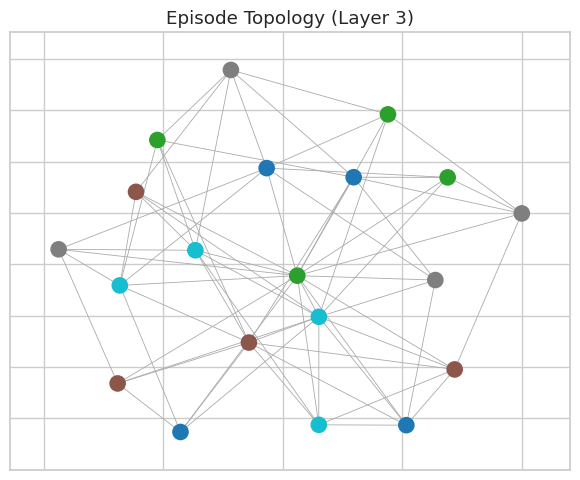

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


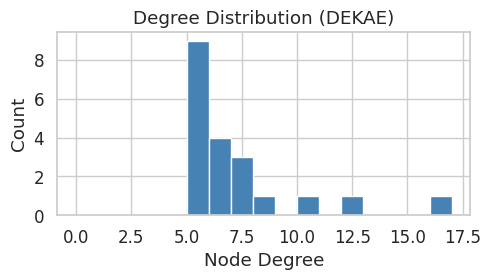

Plots 3/4/5 require training history & real data — run after train().


In [20]:
# ── Section 17: Visualization Suite ──────────────────────────────────────────
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import networkx as nx
from sklearn.manifold import TSNE

sns.set_theme(style="whitegrid", font_scale=1.1)
SAVE_DIR = RESULTS_DIR / "figures"
SAVE_DIR.mkdir(exist_ok=True)


# ── Plot 1: Graph Topology per GNN Layer ─────────────────────────────────────

def plot_topology(A: torch.Tensor, labels: torch.Tensor, title: str = "",
                  save_path=None):
    """Visualise an episode graph coloured by class label."""
    N = A.size(0)
    A_np = (A > 0.01).float().cpu().numpy()
    G    = nx.from_numpy_array(A_np)

    label_list = labels.cpu().tolist()
    cmap = plt.cm.get_cmap("tab10", max(label_list) + 1)
    colors = [cmap(l) for l in label_list]

    fig, ax = plt.subplots(figsize=(6, 5))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx(G, pos, node_color=colors,
                     with_labels=False, node_size=120,
                     edge_color="#aaa", width=0.6, ax=ax)
    ax.set_title(title)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=120)
    plt.show()


# ── Plot 2: Degree Distribution Histogram ─────────────────────────────────────

def plot_degree_distribution(A: torch.Tensor, title: str = "", save_path=None):
    A_no_diag = A.clone(); A_no_diag.fill_diagonal_(0)
    degrees = (A_no_diag > 0).float().sum(dim=1).cpu().numpy()
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.hist(degrees, bins=range(int(degrees.max()) + 2),
            color="steelblue", edgecolor="white")
    ax.set_xlabel("Node Degree")
    ax.set_ylabel("Count")
    ax.set_title(title or "Degree Distribution")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=120)
    plt.show()


# ── Plot 3: Graph Density Curve over Training ─────────────────────────────────

def plot_density_curve(history: list, save_path=None):
    epochs    = [h["epoch"] for h in history]
    densities = [h.get("graph_density", 0) for h in history]
    fig, ax   = plt.subplots(figsize=(6, 3))
    ax.plot(epochs, densities, color="coral", linewidth=2)
    ax.axhline(0.5, ls="--", color="red", alpha=0.6, label="Collapse threshold (0.5)")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Graph Density")
    ax.set_title("Graph Density over Training (monitor for collapse)")
    ax.legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=120)
    plt.show()


# ── Plot 4: t-SNE Before / After Dynamic Topology ────────────────────────────

def plot_tsne(H_before: torch.Tensor, H_after: torch.Tensor,
              labels: torch.Tensor, save_path=None):
    H_all  = torch.cat([H_before, H_after], dim=0).cpu().detach().numpy()
    labels_np = labels.cpu().numpy()
    tsne   = TSNE(n_components=2, perplexity=15, random_state=42)
    emb    = tsne.fit_transform(H_all)
    N      = H_before.size(0)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for ax, title, start, end in zip(
            axes,
            ["Before (H⁰)", "After Dynamic Topology (Hᴸ)"],
            [0, N], [N, 2 * N]):
        sc = ax.scatter(emb[start:end, 0], emb[start:end, 1],
                        c=labels_np, cmap="tab10", s=40, alpha=0.8)
        ax.set_title(title); ax.axis("off")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=120)
    plt.show()


# ── Plot 5: Node Degree vs. Sample Difficulty ─────────────────────────────────

def plot_degree_vs_difficulty(model: DEKAEModel, episode_fn,
                               n_way: int, k_shot: int, n_query: int,
                               n_episodes: int = 600, save_path=None):
    """
    Bin query nodes into easy / medium / hard tertiles by margin difficulty
    d_i = s1(i) - s2(i)  (smaller margin = harder sample).
    Show median node degree per bin with 95% CI error bars.
    """
    model.eval()
    margin_diffs, degrees = [], []

    with torch.no_grad():
        for _ in tqdm(range(n_episodes), desc="Difficulty analysis"):
            s_imgs, s_lbl, q_imgs, q_lbl = episode_fn(n_way, k_shot, n_query)
            s_imgs = s_imgs.to(DEVICE); s_lbl = s_lbl.to(DEVICE)
            q_imgs = q_imgs.to(DEVICE)

            logits, _, mets = model(s_imgs, s_lbl, q_imgs)

            # Margin difficulty: difference between top-2 cosine similarities
            sorted_logits, _ = logits.sort(dim=1, descending=True)
            margin = (sorted_logits[:, 0] - sorted_logits[:, 1]).cpu().numpy()
            margin_diffs.extend(margin.tolist())

            # Per-query node degree from last A' (approximate via avg_degree here)
            # For a precise version, expose per-node degree from forward pass
            avg_d = mets.get("avg_degree", 0)
            degrees.extend([avg_d] * logits.size(0))

    margin_arr  = np.array(margin_diffs)
    degree_arr  = np.array(degrees)

    tertile1, tertile2 = np.percentile(margin_arr, [33, 66])
    bins = {"Hard\n(low margin)"  : degree_arr[margin_arr <= tertile1],
            "Medium"              : degree_arr[(margin_arr > tertile1) & (margin_arr <= tertile2)],
            "Easy\n(high margin)" : degree_arr[margin_arr > tertile2]}

    labels_plot  = list(bins.keys())
    means  = [np.median(v) for v in bins.values()]
    cis    = [1.96 * np.std(v) / max(np.sqrt(len(v)), 1) for v in bins.values()]

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.bar(labels_plot, means, yerr=cis, color=["#e74c3c", "#f39c12", "#2ecc71"],
           capsize=6, edgecolor="white")
    ax.set_ylabel("Average Node Degree")
    ax.set_title("Node Degree vs. Sample Difficulty\n(Hard samples → more neighbours)")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=120)
    plt.show()


# ── Demo: run all plots on the toy model ─────────────────────────────────────

# Plot 1 — topology
_labels_demo = torch.cat([torch.full((4,), c) for c in range(5)]).to(DEVICE)
plot_topology(_A_dyn, _labels_demo, title="Episode Topology (Layer 3)",
              save_path=str(SAVE_DIR / "topology_layer3.png"))

# Plot 2 — degree distribution
plot_degree_distribution(_A_dyn, "Degree Distribution (DEKAE)",
                         save_path=str(SAVE_DIR / "degree_dist.png"))

# Plot 3 — density curve (requires history from train())
# Uncomment after running train():
# plot_density_curve(history, save_path=str(SAVE_DIR / "density_curve.png"))

# Plot 4 — t-SNE (requires H_before, H_after, labels from a real forward pass)
print("Plots 3/4/5 require training history & real data — run after train().")